In [10]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *
from MPRA_predict.metrics import *

In [11]:
MPRA_df = pd.read_csv('../data/Agarwal_MPRA/Agarwal_MPRA_Sei_feature_norm_0601.csv')
MPRA_df

,seq,chr,HepG2,K562,WTC11,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF,WTC11_DNase,WTC11_H3K4me3,WTC11_H3K27ac,WTC11_H3K27me3,WTC11_H3K4me1,WTC11_H3K36me3,WTC11_H3K9me3,WTC11_CTCF
0,AGGACCGGATCAACTGTAGGACCAGGCTCTGCCTCCTTCTCTCTCC...,chr1,0.633,0.080,-0.387,1.535,2.061,2.047,1.445,1.679,2.167,1.980,0.949,1.241,1.943,1.547,1.742,1.079,2.303,NaN,0.865,1.491,1.791,2.092,0.850,2.485,2.208,2.073,0
1,AGGACCGGATCAACTTGTACTTGCCTTAGGAGGTCAAACACATTAG...,chr10,-1.157,-1.147,-1.507,0.596,0.944,0.511,2.020,1.091,1.265,0.080,0.563,0.667,0.920,0.745,1.832,1.244,1.184,NaN,0.635,0.759,1.303,0.981,1.634,1.744,1.092,1.157,0
2,AGGACCGGATCAACTTAGCTCAACACAAATCCATCACTGAAAGCAG...,chr10,-0.066,0.186,0.655,3.281,1.192,0.528,0.428,1.521,1.993,0.645,5.599,2.986,1.780,1.329,-0.390,1.212,1.596,NaN,5.660,4.618,1.828,1.022,1.140,0.918,0.830,0.280,0
3,AGGACCGGATCAACTGACCCTAAATCAGTATGGGGAAAGGTCCCCA...,chr10,0.846,1.212,-0.637,1.937,1.732,2.029,1.317,2.393,1.287,0.645,1.059,2.013,1.823,2.216,0.896,1.891,1.185,NaN,1.090,2.844,2.069,3.393,1.651,2.774,1.128,0.303,0
4,AGGACCGGATCAACTGTGATCTCAGCTTACTGCAACCTCTGCCTCC...,chr10,-0.784,-0.630,-0.612,0.679,-0.600,-0.955,-1.718,-0.511,-0.012,0.863,3.078,-0.030,-0.948,-1.253,-1.965,-1.452,-0.305,NaN,3.059,0.417,-1.092,-2.258,-0.999,-1.960,-0.190,-0.365,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56970,AGGACCGGATCAACTCCAAGTCTGCCATCGTGTTCAGAAGGGCCAG...,chrnan,-1.192,-1.080,-1.680,0.577,1.185,1.082,1.210,0.795,1.031,0.415,0.415,0.216,1.027,0.816,1.490,0.531,1.050,NaN,0.251,0.076,0.848,0.403,1.001,0.443,0.972,0.831,0
56971,AGGACCGGATCAACTCCAAGTCTGCCATCGTGTTCAGAAGGGCCAG...,chrnan,-0.582,-1.094,-1.637,1.086,1.397,1.240,0.930,1.218,0.671,-0.188,0.142,0.951,1.414,1.197,0.485,1.764,-0.004,NaN,0.170,0.001,0.274,-0.122,0.198,0.194,-0.047,0.292,0
56972,AGGACCGGATCAACTCCAAGTCTGCCATCGTGTTCATGTTTGCTTT...,chrnan,-0.855,-0.554,-1.083,0.897,1.168,1.164,0.341,1.228,0.844,-0.155,0.689,3.845,2.240,2.917,0.026,2.976,0.018,NaN,1.846,0.996,0.945,0.311,1.910,1.312,0.342,-0.920,0
56973,AGGACCGGATCAACTCCAAGTCTGCCATCGTGTTCAGAAGGGCCAG...,chrnan,-1.231,-0.927,-1.606,0.037,0.365,0.156,0.654,0.166,0.291,-0.115,-0.026,0.206,0.611,0.560,0.805,0.780,0.063,NaN,0.026,-0.198,0.259,0.083,0.298,0.188,0.028,0.159,0


In [12]:
cell_types = ['K562', 'HepG2', 'WTC11']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

In [13]:
data_split_dict = {}
data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)

data_split_dict['chrom'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(1, 23)) + ['X', 'Y'])])
data_split_dict['not_chrom'] = ~data_split_dict['chrom']

data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in (list(range(3, 23)) + ['X', 'Y'])])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test'] = MPRA_df['chr'].isin(['chr2'])

MPRA_df['std'] = MPRA_df[cell_types].std(axis=1, skipna=True)
threshold = np.percentile(MPRA_df['std'].dropna(), 90)
data_split_dict['diff'] = (MPRA_df['std'] > threshold)
data_split_dict['const'] = ~data_split_dict['diff']


# for key in data_split_dict:
#     print(key, data_split_dict[key].sum())

# keys = list(data_split_dict.keys())
# for k1 in keys:
#     for k2 in keys:
#         data_split_dict[f'{k1}_{k2}'] = data_split_dict[k1] & data_split_dict[k2]

In [21]:
# y_pred = np.load(f'../saved/0529_Gosai_MPRA_MyResTransformer3_seq_epi/0530_033808/Agarwal_MPRA_pred_2.npy')
y_pred = np.load(f'../saved/0529_Gosai_MPRA_MyResTransformer3_seq_epi/0530_033808/Agarwal_MPRA_pred.npy')
cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred
MPRA_df

,seq,chr,HepG2,K562,WTC11,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF,WTC11_DNase,WTC11_H3K4me3,WTC11_H3K27ac,WTC11_H3K27me3,WTC11_H3K4me1,WTC11_H3K36me3,WTC11_H3K9me3,WTC11_CTCF,std,K562_pred,HepG2_pred,WTC11_pred
0,AGGACCGGATCAACTGTAGGACCAGGCTCTGCCTCCTTCTCTCTCC...,chr1,0.633,0.080,-0.387,1.535,2.061,2.047,1.445,1.679,2.167,1.980,0.949,1.241,1.943,1.547,1.742,1.079,2.303,NaN,0.865,1.491,1.791,2.092,0.850,2.485,2.208,2.073,0,0.511,3.434,3.400,3.515
1,AGGACCGGATCAACTTGTACTTGCCTTAGGAGGTCAAACACATTAG...,chr10,-1.157,-1.147,-1.507,0.596,0.944,0.511,2.020,1.091,1.265,0.080,0.563,0.667,0.920,0.745,1.832,1.244,1.184,NaN,0.635,0.759,1.303,0.981,1.634,1.744,1.092,1.157,0,0.205,2.399,2.373,2.593
2,AGGACCGGATCAACTTAGCTCAACACAAATCCATCACTGAAAGCAG...,chr10,-0.066,0.186,0.655,3.281,1.192,0.528,0.428,1.521,1.993,0.645,5.599,2.986,1.780,1.329,-0.390,1.212,1.596,NaN,5.660,4.618,1.828,1.022,1.140,0.918,0.830,0.280,0,0.366,2.500,2.570,3.265
3,AGGACCGGATCAACTGACCCTAAATCAGTATGGGGAAAGGTCCCCA...,chr10,0.846,1.212,-0.637,1.937,1.732,2.029,1.317,2.393,1.287,0.645,1.059,2.013,1.823,2.216,0.896,1.891,1.185,NaN,1.090,2.844,2.069,3.393,1.651,2.774,1.128,0.303,0,0.979,2.835,2.849,3.088
4,AGGACCGGATCAACTGTGATCTCAGCTTACTGCAACCTCTGCCTCC...,chr10,-0.784,-0.630,-0.612,0.679,-0.600,-0.955,-1.718,-0.511,-0.012,0.863,3.078,-0.030,-0.948,-1.253,-1.965,-1.452,-0.305,NaN,3.059,0.417,-1.092,-2.258,-0.999,-1.960,-0.190,-0.365,0,0.095,0.560,0.467,0.257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56970,AGGACCGGATCAACTCCAAGTCTGCCATCGTGTTCAGAAGGGCCAG...,chrnan,-1.192,-1.080,-1.680,0.577,1.185,1.082,1.210,0.795,1.031,0.415,0.415,0.216,1.027,0.816,1.490,0.531,1.050,NaN,0.251,0.076,0.848,0.403,1.001,0.443,0.972,0.831,0,0.319,1.036,0.934,0.794
56971,AGGACCGGATCAACTCCAAGTCTGCCATCGTGTTCAGAAGGGCCAG...,chrnan,-0.582,-1.094,-1.637,1.086,1.397,1.240,0.930,1.218,0.671,-0.188,0.142,0.951,1.414,1.197,0.485,1.764,-0.004,NaN,0.170,0.001,0.274,-0.122,0.198,0.194,-0.047,0.292,0,0.528,3.313,3.250,2.910
56972,AGGACCGGATCAACTCCAAGTCTGCCATCGTGTTCATGTTTGCTTT...,chrnan,-0.855,-0.554,-1.083,0.897,1.168,1.164,0.341,1.228,0.844,-0.155,0.689,3.845,2.240,2.917,0.026,2.976,0.018,NaN,1.846,0.996,0.945,0.311,1.910,1.312,0.342,-0.920,0,0.265,1.713,1.751,1.498
56973,AGGACCGGATCAACTCCAAGTCTGCCATCGTGTTCAGAAGGGCCAG...,chrnan,-1.231,-0.927,-1.606,0.037,0.365,0.156,0.654,0.166,0.291,-0.115,-0.026,0.206,0.611,0.560,0.805,0.780,0.063,NaN,0.026,-0.198,0.259,0.083,0.298,0.188,0.028,0.159,0,0.340,1.595,1.781,1.483


In [22]:
for data_split in ['total', 'const', 'diff']:
    pearson_df = pd.DataFrame(index=cell_types, columns=cell_types_pred)
    for cell_type in cell_types:
        for cell_type_pred in cell_types_pred:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_pred}']
            r, p = pearson(x, y)
            pearson_df.loc[cell_type, cell_type_pred] = r
    print(data_split)
    print(pearson_df)

total
      K562_pred HepG2_pred WTC11_pred
K562      0.498      0.428      0.453
HepG2     0.524      0.540      0.499
WTC11     0.442      0.444      0.519
const
      K562_pred HepG2_pred WTC11_pred
K562      0.515      0.459      0.492
HepG2     0.528      0.537      0.514
WTC11     0.477      0.473      0.543
diff
      K562_pred HepG2_pred WTC11_pred
K562      0.298      0.137      0.179
HepG2     0.386      0.477      0.411
WTC11     0.314      0.343      0.444


0.49802418562416384


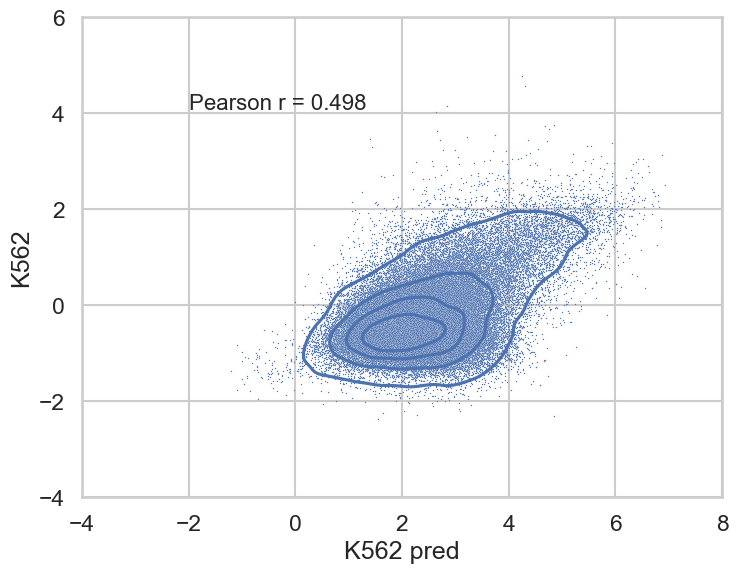

In [25]:
plt.figure(figsize=(8,6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

x = MPRA_df['K562_pred']
y = MPRA_df['K562']
sns.scatterplot(x=x, y=y, s=1)
sns.kdeplot(x=x[:10000], y=y[:10000], n_levels=5)
r, _ = pearson(x, y)
print(r)
plt.text(-2, 4, f'Pearson r = {r:.3f}', fontsize=16, ha='left', va='bottom')
plt.xlim(-4, 8)
plt.ylim(-4, 6)
plt.xlabel('K562 pred')
plt.ylabel('K562')
plt.savefig('figures/Agarwal_MPRA_K562_pred.png', dpi=400)

0.7098621749945357


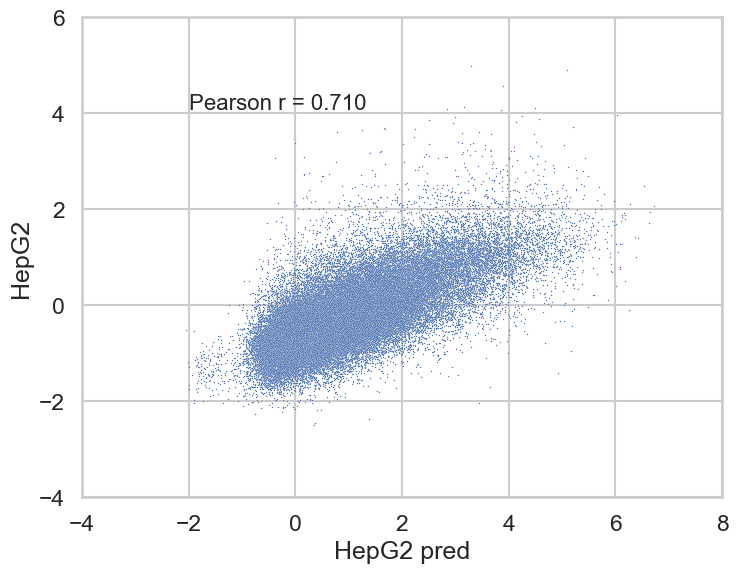

In [14]:
plt.figure(figsize=(8,6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

x = MPRA_df['HepG2_pred']
y = MPRA_df['HepG2']
sns.scatterplot(x=x, y=y, s=1)
r, _ = pearson(x, y)
print(r)
plt.text(-2, 4, f'Pearson r = {r:.3f}', fontsize=16, ha='left', va='bottom')
plt.xlim(-4, 8)
plt.ylim(-4, 6)
plt.xlabel('HepG2 pred')
plt.ylabel('HepG2')

plt.savefig('figures/Agarwal_MPRA_HepG2_pred.png', dpi=400)

0.6199585979278094


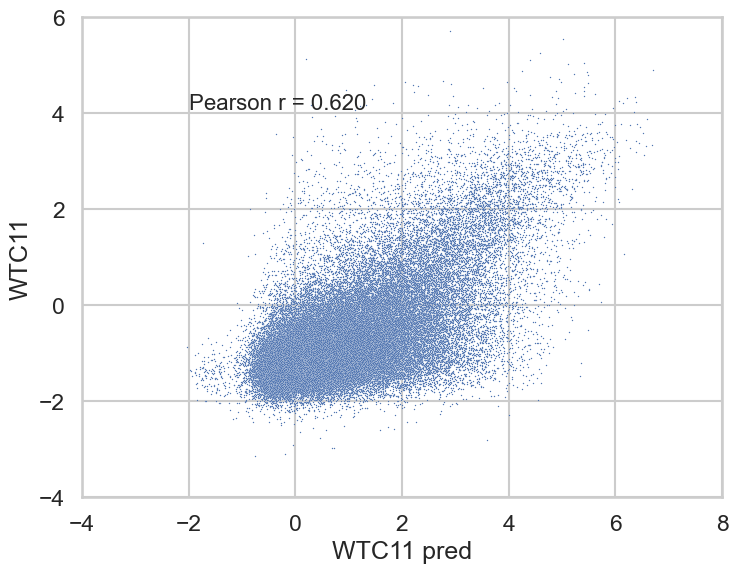

In [15]:
plt.figure(figsize=(8,6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

x = MPRA_df['WTC11_pred']
y = MPRA_df['WTC11']
sns.scatterplot(x=x, y=y, s=1)
r, _ = pearson(x, y)
print(r)
plt.text(-2, 4, f'Pearson r = {r:.3f}', fontsize=16, ha='left', va='bottom')
plt.xlim(-4, 8)
plt.ylim(-4, 6)
plt.xlabel('WTC11 pred')
plt.ylabel('WTC11')

plt.savefig('figures/Agarwal_MPRA_WTC11_pred.png', dpi=400)

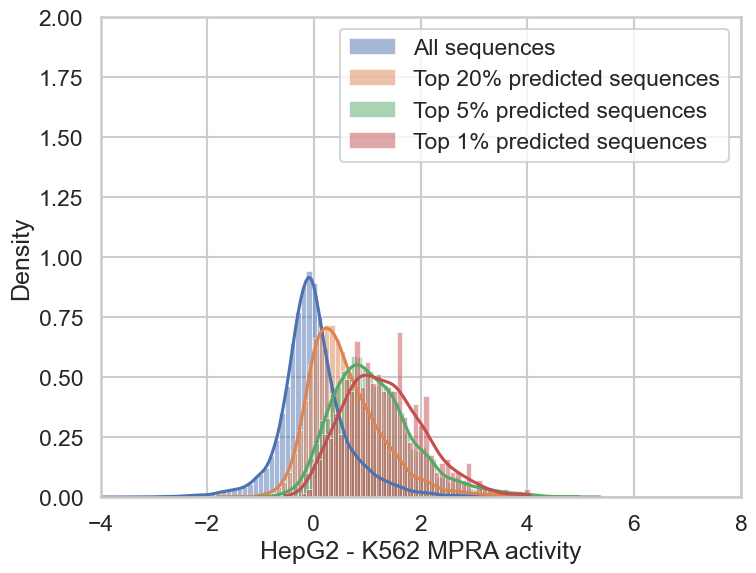

In [13]:
MPRA_df['HepG2-K562'] = MPRA_df['HepG2'] - MPRA_df['K562']
MPRA_df['HepG2-K562_pred'] = MPRA_df['HepG2_pred'] - MPRA_df['K562_pred']


plt.figure(figsize=(8,6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

sns.histplot(MPRA_df['HepG2-K562'], binwidth=1e-1, stat='density', alpha=0.5, label='All sequences', kde=True)

threshold = np.percentile(MPRA_df['HepG2-K562_pred'], 80)
filtered_df = MPRA_df[MPRA_df['HepG2-K562_pred'] > threshold]
sns.histplot(filtered_df['HepG2-K562'], binwidth=1e-1, stat='density', alpha=0.5, label='Top 20% predicted sequences', kde=True)

threshold = np.percentile(MPRA_df['HepG2-K562_pred'], 95)
filtered_df = MPRA_df[MPRA_df['HepG2-K562_pred'] > threshold]
sns.histplot(filtered_df['HepG2-K562'], binwidth=1e-1, stat='density', alpha=0.5, label='Top 5% predicted sequences', kde=True)

threshold = np.percentile(MPRA_df['HepG2-K562_pred'], 99)
filtered_df = MPRA_df[MPRA_df['HepG2-K562_pred'] > threshold]
sns.histplot(filtered_df['HepG2-K562'], binwidth=1e-1, stat='density', alpha=0.5, label='Top 1% predicted sequences', kde=True)

plt.xlim(-4, 8)
plt.ylim(0, 2)
plt.xlabel('HepG2 - K562 MPRA activity')
plt.ylabel('Density')
plt.legend()
plt.savefig('figures/Agarwal_MPRA_HepG2-K562_sequence_prioritization.png', dpi=400)

In [7]:
# seq feature
# train 3 cell types

cell_types = ['K562', 'HepG2']

y_pred = np.load(f'../saved/0504_GosaiMPRA_MyResTransformer3/0504_134132/Agarwal_pred.npy')
cell_types_pred = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cell_types_pred] = y_pred

In [8]:
# 预测值和真实值的相关性

for data_split in ['train', 'test', 'const', 'diff']:
    corr_matrix = pd.DataFrame(index=cell_types, columns=cell_types_pred)
    for cell_type in cell_types:
        for cell_type_pred in cell_types_pred:
            condition = data_split_dict[data_split]
            df = MPRA_df[condition]
            x = df[f'{cell_type}']
            y = df[f'{cell_type_pred}']
            r, p = pearson(x, y)
            corr_matrix.loc[cell_type, cell_type_pred] = r
    print(data_split)
    print(corr_matrix)

train
      K562_pred HepG2_pred
K562      0.727      0.617
HepG2     0.595      0.706
test
      K562_pred HepG2_pred
K562      0.702      0.567
HepG2     0.530      0.676
const
      K562_pred HepG2_pred
K562      0.746      0.698
HepG2     0.690      0.734
diff
      K562_pred HepG2_pred
K562      0.558     -0.027
HepG2     0.042      0.609


0.720309738396121


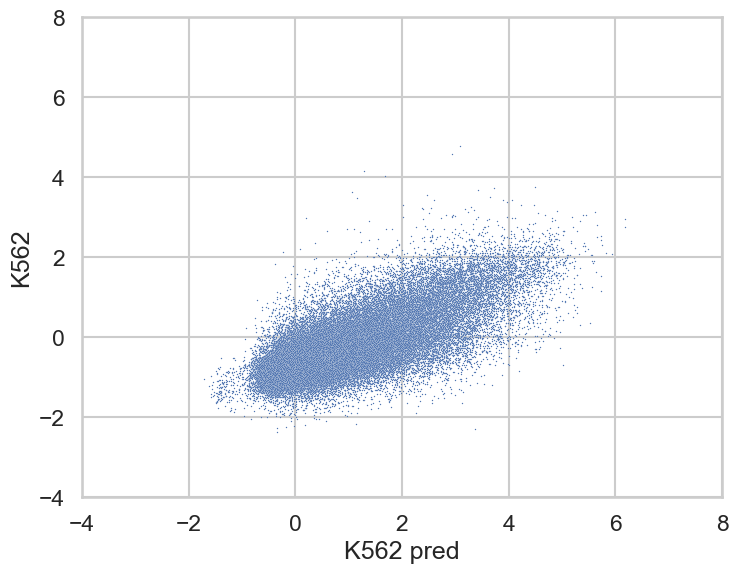

In [8]:
plt.figure(figsize=(8,6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

x = MPRA_df['K562_pred']
y = MPRA_df['K562']
sns.scatterplot(x=x, y=y, s=1)
r, _ = pearson(x, y)
print(r)
plt.xlim(-4, 8)
plt.ylim(-4, 8)
plt.xlabel('K562 pred')
plt.ylabel('K562')

plt.savefig('figures/Agarwal_MPRA_K562_pred.png', dpi=400)

0.7098594699892655


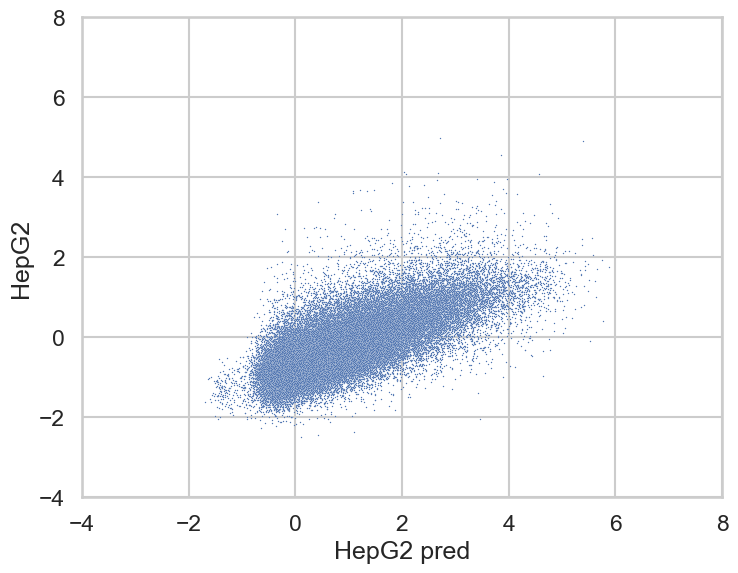

In [9]:
plt.figure(figsize=(8,6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

x = MPRA_df['HepG2_pred']
y = MPRA_df['HepG2']
sns.scatterplot(x=x, y=y, s=1)
r, _ = pearson(x, y)
print(r)
plt.xlim(-4, 8)
plt.ylim(-4, 8)
plt.xlabel('HepG2 pred')
plt.ylabel('HepG2')

plt.savefig('figures/Agarwal_MPRA_HepG2_pred.png', dpi=400)

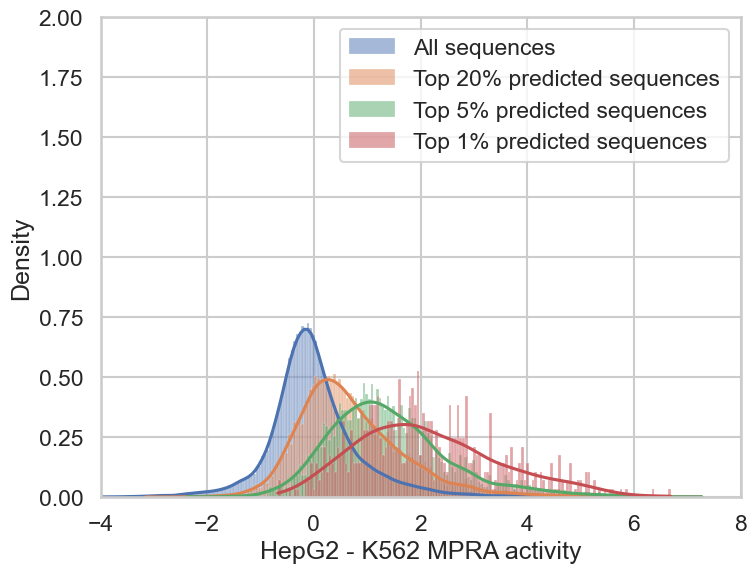

In [30]:
cell_types = ['K562', 'HepG2']
cell_types_pred = [f'{cell}_pred' for cell in cell_types]

MPRA_df['HepG2-K562'] = MPRA_df['HepG2'] - MPRA_df['K562']
MPRA_df['HepG2-K562_pred'] = MPRA_df['HepG2_pred'] - MPRA_df['K562_pred']


plt.figure(figsize=(8,6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

sns.histplot(MPRA_df['HepG2-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='All sequences', kde=True)

threshold = np.percentile(MPRA_df['HepG2-K562_pred'], 80)
filtered_df = MPRA_df[MPRA_df['HepG2-K562_pred'] > threshold]
sns.histplot(filtered_df['HepG2-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 20% predicted sequences', kde=True)

threshold = np.percentile(MPRA_df['HepG2-K562_pred'], 95)
filtered_df = MPRA_df[MPRA_df['HepG2-K562_pred'] > threshold]
sns.histplot(filtered_df['HepG2-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 5% predicted sequences', kde=True)

threshold = np.percentile(MPRA_df['HepG2-K562_pred'], 99)
filtered_df = MPRA_df[MPRA_df['HepG2-K562_pred'] > threshold]
sns.histplot(filtered_df['HepG2-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 1% predicted sequences', kde=True)

plt.xlim(-4, 8)
plt.ylim(0, 2)
plt.xlabel('HepG2 - K562 MPRA activity')
plt.ylabel('Density')
plt.legend()
plt.savefig('figures/Agarwal_MPRA_HepG2-K562_sequence_prioritization.png', dpi=400)

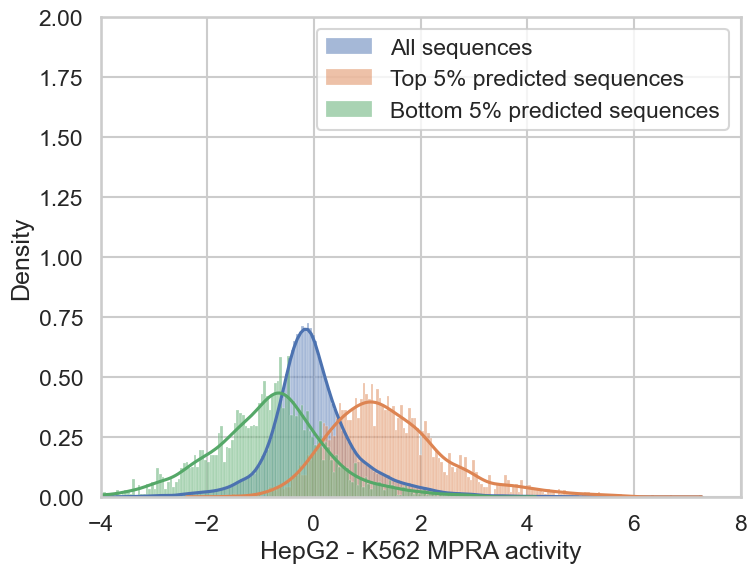

In [31]:
cell_types = ['K562', 'HepG2']
cell_types_pred = [f'{cell}_pred' for cell in cell_types]

MPRA_df['HepG2-K562'] = MPRA_df['HepG2'] - MPRA_df['K562']
MPRA_df['HepG2-K562_pred'] = MPRA_df['HepG2_pred'] - MPRA_df['K562_pred']


plt.figure(figsize=(8,6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

sns.histplot(MPRA_df['HepG2-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='All sequences', kde=True)

# threshold = np.percentile(MPRA_df['HepG2-K562_pred'], 80)
# filtered_df = MPRA_df[MPRA_df['HepG2-K562_pred'] > threshold]
# sns.histplot(filtered_df['HepG2-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 20% predicted sequences', kde=True)

threshold = np.percentile(MPRA_df['HepG2-K562_pred'], 95)
filtered_df = MPRA_df[MPRA_df['HepG2-K562_pred'] > threshold]
sns.histplot(filtered_df['HepG2-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 5% predicted sequences', kde=True)


threshold = np.percentile(MPRA_df['HepG2-K562_pred'], 5)
filtered_df = MPRA_df[MPRA_df['HepG2-K562_pred'] < threshold]
sns.histplot(filtered_df['HepG2-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='Bottom 5% predicted sequences', kde=True)

# threshold = np.percentile(MPRA_df['HepG2-K562_pred'], 99)
# filtered_df = MPRA_df[MPRA_df['HepG2-K562_pred'] > threshold]
# sns.histplot(filtered_df['HepG2-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 1% predicted sequences', kde=True)

plt.xlim(-4, 8)
plt.ylim(0, 2)
plt.xlabel('HepG2 - K562 MPRA activity')
plt.ylabel('Density')
plt.legend()
plt.savefig('figures/Agarwal_MPRA_HepG2-K562_sequence_prioritization.png', dpi=400)

In [27]:
MPRA_df

,Unnamed: 0,seq,chr,HepG2,K562,WTC11,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF,K562_pred,HepG2_pred,std
0,0,AGGACCGGATCAACTGTAGGACCAGGCTCTGCCTCCTTCTCTCTCC...,chr1,1.114,0.352,-0.387,-0.602,0.322,0.220,0.706,0.009,0.340,0.960,-0.687,-0.750,0.193,-0.057,0.843,-0.539,1.015,1.033,-0.759,0.584,0.554,0.539
1,1,AGGACCGGATCAACTTGTACTTGCCTTAGGAGGTCAAACACATTAG...,chr10,-1.315,-1.246,-1.507,-1.419,-0.894,-1.021,0.389,-0.788,-0.499,-1.055,-0.881,-1.287,-0.984,-0.786,0.934,-0.524,0.043,0.889,-0.875,-0.812,-0.807,0.049
2,2,AGGACCGGATCAACTTAGCTCAACACAAATCCATCACTGAAAGCAG...,chr10,0.166,0.490,0.655,0.950,-0.619,-1.073,-1.610,-0.786,0.437,-0.477,1.651,0.886,0.005,-0.289,-1.309,-0.677,-0.051,-1.905,1.663,-0.002,0.030,0.229
3,3,AGGACCGGATCAACTGACCCTAAATCAGTATGGGGAAAGGTCCCCA...,chr10,1.404,1.826,-0.637,-0.241,-0.046,0.359,0.210,0.698,-0.461,-0.468,-0.632,-0.026,0.054,0.569,-0.011,0.542,-0.215,0.113,-0.645,0.283,0.375,0.299
4,4,AGGACCGGATCAACTGTGATCTCAGCTTACTGCAACCTCTGCCTCC...,chr10,-0.809,-0.573,-0.612,-1.352,-2.547,-2.427,-2.914,-2.849,-2.305,-0.271,0.384,-1.941,-3.134,-2.488,-2.899,-2.863,-2.150,-1.598,0.349,-0.422,-0.427,0.167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56970,56970,AGGACCGGATCAACTCCAAGTCTGCCATCGTGTTCAGAAGGGCCAG...,chrnan,-1.363,-1.159,-1.680,-1.440,-0.627,-0.631,0.070,-1.188,-0.831,-0.715,-0.956,-1.710,-0.861,-0.698,0.588,-1.363,-0.085,0.308,-1.069,-0.573,-0.570,0.144
56971,56971,AGGACCGGATCAACTCCAAGTCTGCCATCGTGTTCAGAAGGGCCAG...,chrnan,-0.535,-1.177,-1.637,-0.992,-0.404,-0.481,-0.707,-0.460,-1.205,-1.298,-1.093,-1.021,-0.416,-0.405,-0.426,-0.075,-1.632,0.087,-1.110,0.551,0.563,0.454
56972,56972,AGGACCGGATCAACTCCAAGTCTGCCATCGTGTTCATGTTTGCTTT...,chrnan,-0.906,-0.474,-1.083,-1.146,-0.661,-0.507,-0.687,-0.478,-0.520,-1.606,-0.818,1.691,0.535,1.078,-0.889,1.933,-2.140,-3.367,-0.264,0.038,0.096,0.305
56973,56973,AGGACCGGATCAACTCCAAGTCTGCCATCGTGTTCAGAAGGGCCAG...,chrnan,-1.416,-0.960,-1.606,-1.915,-1.521,-1.359,-0.612,-1.940,-1.657,-1.336,-1.177,-1.719,-1.340,-0.952,-0.103,-1.088,-1.158,0.085,-1.183,-0.576,-0.571,0.323


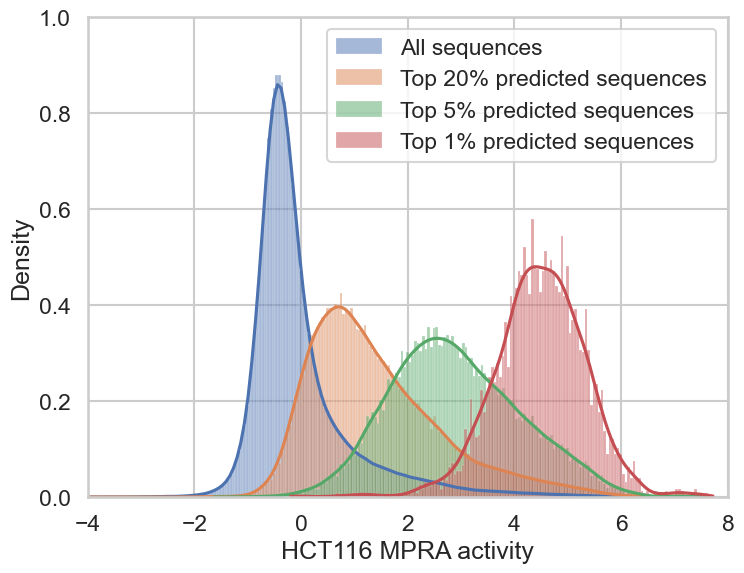

In [51]:
MPRA_df = MPRA_df[MPRA_df['HCT116'].notna()]

plt.figure(figsize=(8,6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

sns.histplot(MPRA_df['HCT116'], binwidth=5e-2, stat='density', alpha=0.5, label='All sequences', kde=True)

threshold = np.percentile(MPRA_df['HCT116_pred'], 80)
filtered_df = MPRA_df[MPRA_df['HCT116_pred'] > threshold]
sns.histplot(filtered_df['HCT116'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 20% predicted sequences', kde=True)

threshold = np.percentile(MPRA_df['HCT116_pred'], 95)
filtered_df = MPRA_df[MPRA_df['HCT116_pred'] > threshold]
sns.histplot(filtered_df['HCT116'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 5% predicted sequences', kde=True)

threshold = np.percentile(MPRA_df['HCT116_pred'], 99)
filtered_df = MPRA_df[MPRA_df['HCT116_pred'] > threshold]
sns.histplot(filtered_df['HCT116'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 1% predicted sequences', kde=True)


plt.xlim(-4, 8)
plt.ylim(0, 1)
plt.xlabel('HCT116 MPRA activity')
plt.ylabel('Density')
plt.legend()
plt.savefig('figures/Gosai_MPRA_HCT116_sequence_prioritization.png', dpi=400)

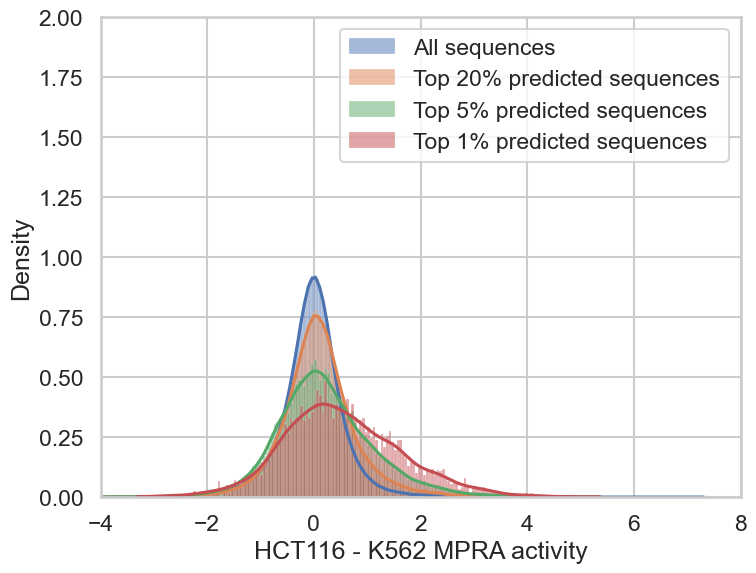

In [50]:
MPRA_df = MPRA_df[MPRA_df['HCT116'].notna()]

cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116']
cell_types_pred = [f'{cell}_pred' for cell in cell_types]

MPRA_df['HCT116-K562'] = MPRA_df['HCT116'] - MPRA_df['K562']
MPRA_df['HCT116-K562_pred'] = MPRA_df['HCT116_pred'] - MPRA_df['K562_pred']


plt.figure(figsize=(8,6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

sns.histplot(MPRA_df['HCT116-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='All sequences', kde=True)

threshold = np.percentile(MPRA_df['HCT116-K562_pred'], 80)
filtered_df = MPRA_df[MPRA_df['HCT116-K562_pred'] > threshold]
sns.histplot(filtered_df['HCT116-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 20% predicted sequences', kde=True)

threshold = np.percentile(MPRA_df['HCT116-K562_pred'], 95)
filtered_df = MPRA_df[MPRA_df['HCT116-K562_pred'] > threshold]
sns.histplot(filtered_df['HCT116-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 5% predicted sequences', kde=True)

threshold = np.percentile(MPRA_df['HCT116-K562_pred'], 99)
filtered_df = MPRA_df[MPRA_df['HCT116-K562_pred'] > threshold]
sns.histplot(filtered_df['HCT116-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 1% predicted sequences', kde=True)

plt.xlim(-4, 8)
plt.ylim(0, 2)
plt.xlabel('HCT116 - K562 MPRA activity')
plt.ylabel('Density')
plt.legend()
plt.savefig('figures/Gosai_MPRA_HCT116-K562_sequence_prioritization.png', dpi=400)

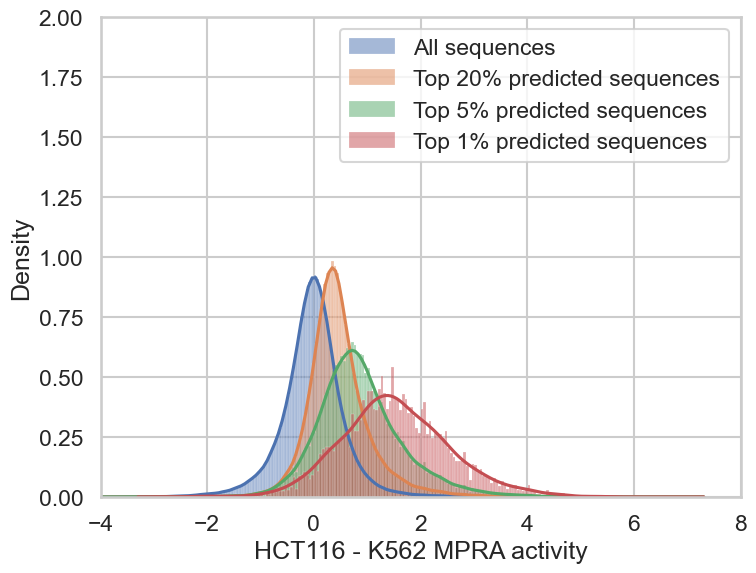

In [56]:
MPRA_df = MPRA_df[MPRA_df['HCT116'].notna()]

cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116']
cell_types_pred = [f'{cell}_pred' for cell in cell_types]

MPRA_df['HCT116-K562'] = MPRA_df['HCT116'] - MPRA_df['K562']
MPRA_df['HCT116-K562_pred'] = MPRA_df['HCT116_pred'] - MPRA_df['K562']
#######MPRA_df['HCT116-K562_pred'] = MPRA_df['HCT116_pred'] - MPRA_df['K562_pred']
#######这里我应该假设已知K562活性吗？

plt.figure(figsize=(8,6), dpi=100)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95)

sns.histplot(MPRA_df['HCT116-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='All sequences', kde=True)

threshold = np.percentile(MPRA_df['HCT116-K562_pred'], 80)
filtered_df = MPRA_df[MPRA_df['HCT116-K562_pred'] > threshold]
sns.histplot(filtered_df['HCT116-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 20% predicted sequences', kde=True)

threshold = np.percentile(MPRA_df['HCT116-K562_pred'], 95)
filtered_df = MPRA_df[MPRA_df['HCT116-K562_pred'] > threshold]
sns.histplot(filtered_df['HCT116-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 5% predicted sequences', kde=True)

threshold = np.percentile(MPRA_df['HCT116-K562_pred'], 99)
filtered_df = MPRA_df[MPRA_df['HCT116-K562_pred'] > threshold]
sns.histplot(filtered_df['HCT116-K562'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 1% predicted sequences', kde=True)

plt.xlim(-4, 8)
plt.ylim(0, 2)
plt.xlabel('HCT116 - K562 MPRA activity')
plt.ylabel('Density')
plt.legend()
plt.savefig('figures/Gosai_MPRA_HCT116-K562_sequence_prioritization.png', dpi=400)

0.2912329242263634


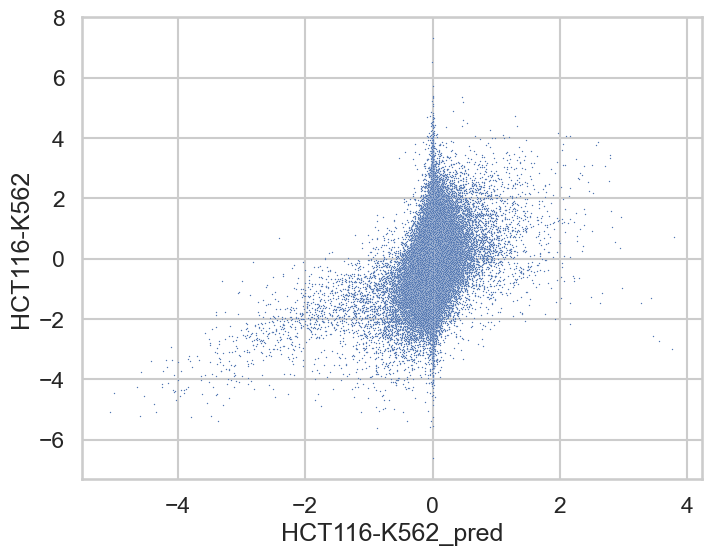

In [41]:
x=MPRA_df['HCT116-K562_pred']
y=MPRA_df['HCT116-K562']
sns.scatterplot(x=x, y=y, s=1)
r, _ = pearson(x, y)
print(r)

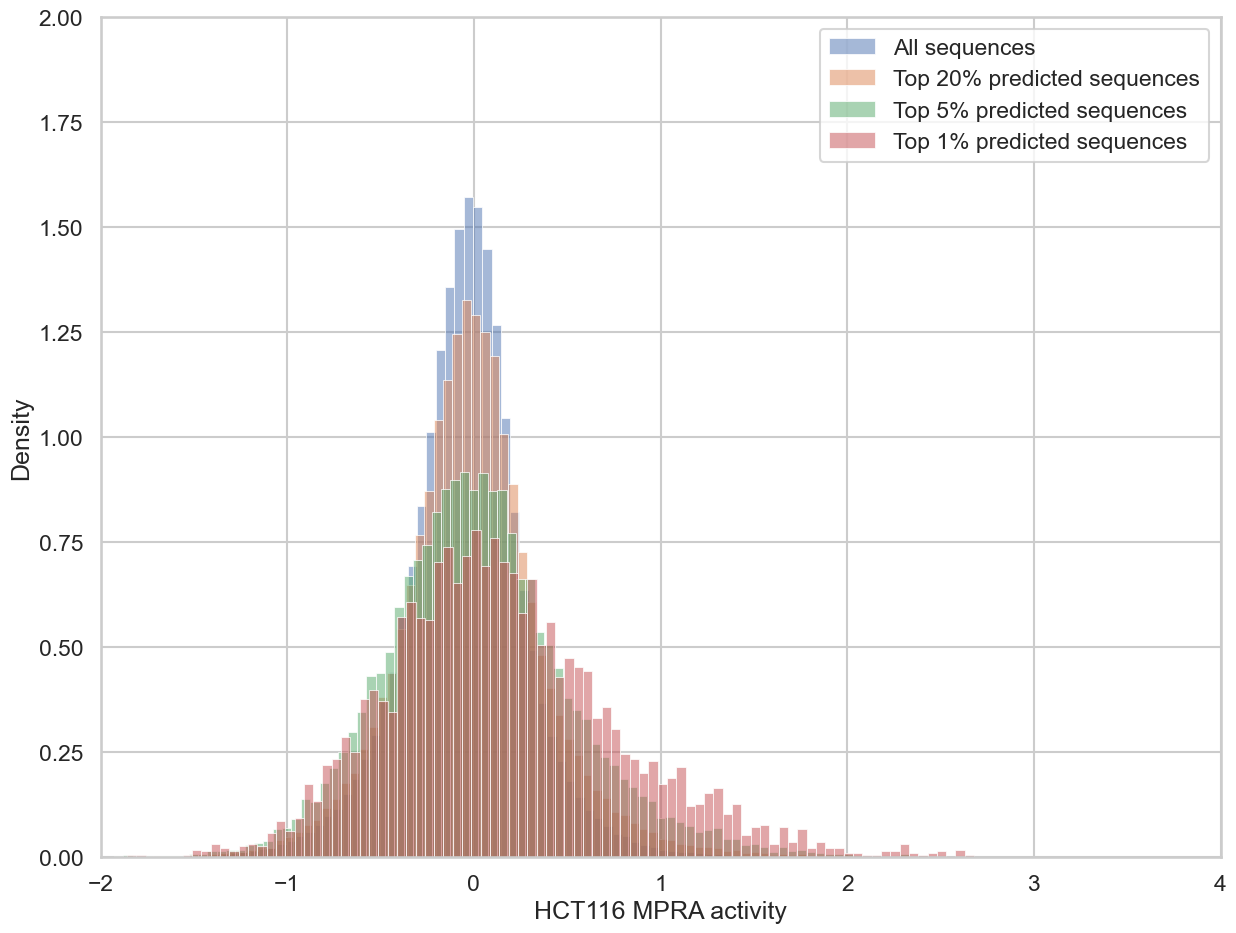

In [39]:
MPRA_df = MPRA_df[MPRA_df['HCT116'].notna()]

cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116']
cell_types_pred = [f'{cell}_pred' for cell in cell_types]

MPRA_df['HCT116_deviation'] = MPRA_df['HCT116'] - MPRA_df[cell_types].mean(axis=1)
MPRA_df['HCT116_pred_deviation'] = MPRA_df['HCT116_pred'] - MPRA_df[cell_types_pred].mean(axis=1)


plt.figure(figsize=(16,12), dpi=100)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)

sns.histplot(MPRA_df['HCT116_deviation'], binwidth=5e-2, stat='density', alpha=0.5, label='All sequences')

threshold = np.percentile(MPRA_df['HCT116_pred_deviation'], 80)
filtered_df = MPRA_df[MPRA_df['HCT116_pred_deviation'] > threshold]
sns.histplot(filtered_df['HCT116_deviation'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 20% predicted sequences')

threshold = np.percentile(MPRA_df['HCT116_pred_deviation'], 95)
filtered_df = MPRA_df[MPRA_df['HCT116_pred_deviation'] > threshold]
sns.histplot(filtered_df['HCT116_deviation'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 5% predicted sequences')

threshold = np.percentile(MPRA_df['HCT116_pred_deviation'], 99)
filtered_df = MPRA_df[MPRA_df['HCT116_pred_deviation'] > threshold]
sns.histplot(filtered_df['HCT116_deviation'], binwidth=5e-2, stat='density', alpha=0.5, label='Top 1% predicted sequences')

plt.xlim(-2, 4)
plt.ylim(0, 2)
plt.xlabel('HCT116 MPRA activity')
plt.ylabel('Density')
plt.legend()
plt.savefig('figures/Gosai_MPRA_HCT116_deviation_sequence_prioritization.png', dpi=400)